# ****DO NOT RUN****, STILL TALKING IT OVER W/ IVELIN

# Logistic regression modeling and interpretation using Yelp reviews

### Objective: 

- Checking and removing the outliers from a linear regression model using Cook's distance
- Visualizing the error distribution using a Q-Q plot
- Presenting final regression model performance including r-squared value

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
from statsmodels import graphics
from patsy import dmatrices
import sys
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
import scipy.stats as stat
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm
import time
try:
    sys.getwindowsversion()
except AttributeError:
    isWindows = False
else:
    isWindows = True

if isWindows:
    import win32api,win32process,win32con
    pid = win32api.GetCurrentProcessId()
    handle = win32api.OpenProcess(win32con.PROCESS_ALL_ACCESS, True, pid)
    win32process.SetPriorityClass(handle, win32process.HIGH_PRIORITY_CLASS)
plt.rcParams['figure.figsize'] = [15, 10]

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Read data

In [2]:
reviews = pd.read_csv('data/ready_data.csv')

y = reviews['Recommended']
X = reviews.copy()
del X['Recommended']

# Logistic Regression

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression(penalty='l2',class_weight='balanced')
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.5f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.79204


In [4]:
def test_accuracy(model, n_splits=5, print_steps=False, params={}):
    accuracies = []
    for i in range(1, n_splits+1):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=i)
        yhat, _ = model(
            X_train=X_train,
            y_train=y_train,
            X_test=X_test,
            **params
        )
        accuracy = float(sum(yhat==y_test)) / len(y_test)
        accuracies.append(accuracy)
        if print_steps:
            matrix = pd.DataFrame(confusion_matrix(y_test, yhat),
                columns=['Predicted 0', 'Predicted 1'],
                index=['Actual 0', 'Actual 1'],
            )
            print('*' * 15 + ' Split %d ' % i + '*' * 15)
            print('Accuracy:', accuracy)
            print(matrix)
            
    return np.mean(accuracies)
    
def find_optimal_accuracy(model, param, param_values, params={}):
    result = {}
    for param_value in tqdm(list(param_values)):
        params_local = params.copy()
        params_local[param] = param_value
        result[param_value] = test_accuracy(model, params=params_local)
    
    result = pd.Series(result).sort_index()
    plt.xlabel(param, fontsize=15)
    plt.ylabel('Accuracy', fontsize=15)
    
    optimal_param = result.argmax()
    optimal_accuracy = result[optimal_param]
    
    if type(param_value) == str:
        result.plot(kind='bar')
    else:
        result.plot()
    plt.show()
    return optimal_param

In [5]:
def logistic_regression_model(X_train, y_train, X_test, **params):

    params['class_weight'] = 'balanced'

    clf = LogisticRegression(**params)
    clf.fit(X_train, y_train)
    return clf.predict(X_test), clf

best_params_logistic = {}

model = logistic_regression_model
accuracy = test_accuracy(model=model, params=best_params_logistic, print_steps=True)
print('-' * 50)
'Average unoptimized accuracy: %f' % accuracy

*************** Split 1 ***************
Accuracy: 0.7920412655475111
          Predicted 0  Predicted 1
Actual 0         6759         1387
Actual 1        14296        52972
*************** Split 2 ***************
Accuracy: 0.7927307926910123
          Predicted 0  Predicted 1
Actual 0         6823         1377
Actual 1        14254        52960
*************** Split 3 ***************
Accuracy: 0.7917495425252605
          Predicted 0  Predicted 1
Actual 0         6715         1336
Actual 1        14369        52994
*************** Split 4 ***************
Accuracy: 0.7899594239796325
          Predicted 0  Predicted 1
Actual 0         6628         1428
Actual 1        14412        52946
*************** Split 5 ***************
Accuracy: 0.7912986978545098
          Predicted 0  Predicted 1
Actual 0         6716         1360
Actual 1        14379        52959
--------------------------------------------------


'Average unoptimized accuracy: 0.791556'

100%|██████████████████████████████████████████| 11/11 [05:07<00:00, 27.94s/it]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.


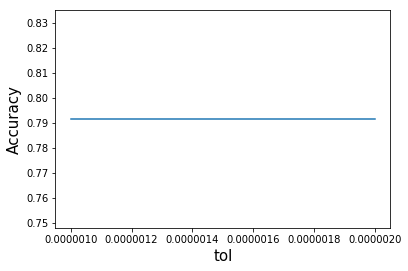

Best tol 1e-06


In [6]:
test_params = [
    ('tol', np.linspace(0.000001, 0.000002, 11))
]

for param, param_values in test_params:
    best_params_logistic[param] = find_optimal_accuracy(
        logistic_regression_model,
        param=param,
        param_values=param_values,
        params=best_params_logistic
    )
    print("Best", param, best_params_logistic[param])
    time.sleep(1)

In [7]:
%%timeit -n1 -r1

accuracy = test_accuracy(
    logistic_regression_model, n_splits=5, params=best_params_logistic)
print('Optimized Logistic Regression Accuracy %f' % accuracy)

Optimized Logistic Regression Accuracy 0.791545
30.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [8]:
kfold = model_selection.KFold(n_splits=10, random_state=7)
scoring = 'accuracy'
results = model_selection.cross_val_score(logreg, X_train, y_train, cv=kfold, scoring=scoring)
print("10-fold cross validation average accuracy: %.5f" % (results.mean()))

10-fold cross validation average accuracy: 0.79159


In [9]:
confusion_matrix = pd.DataFrame(
    metrics.confusion_matrix(y_test, y_pred),
    columns=['Predicted Non Rec', 'Predicted Rec'],
    index=['Actual Non Rec', 'Actual Rec']
)
confusion_matrix

,Predicted Non Rec,Predicted Rec
Actual Non Rec,6669,1370
Actual Rec,14313,53062


In [10]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

        0.0       0.32      0.83      0.46      8039
        1.0       0.97      0.79      0.87     67375

avg / total       0.90      0.79      0.83     75414



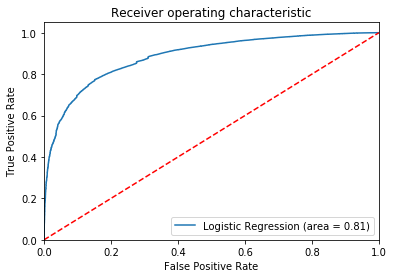

In [11]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [12]:
denom = (2.0*(1.0+np.cosh(logreg.decision_function(X))))
denom = np.tile(denom,(X.shape[1],1)).T
F_ij = np.dot((X/denom).T,X) ## Fisher Information Matrix
Cramer_Rao = np.linalg.inv(F_ij) ## Inverse Information Matrix
sigma_estimates = np.array([np.sqrt(Cramer_Rao[i,i]) for i in range(Cramer_Rao.shape[0])]) # sigma for each coefficient
z_scores = logreg.coef_[0]/sigma_estimates # z-score for eaach model coefficient
p_values = [stat.norm.sf(abs(x))*2 for x in z_scores] ### two tailed test for p-values

In [13]:
data = {'Feature': X.dtypes.index.tolist(), 'Coeff.': logreg.coef_[0].tolist(), 'P_Value': p_values, 'Z_Score': z_scores.tolist()}
data
df = pd.DataFrame(data=data,index=None)
df.round(5).set_index('Feature')

,Coeff.,P_Value,Z_Score
Feature,,,
Profile_Pic_Bool,0.24325,0.00000,17.21007
User_Rating,1.41803,0.00000,24.50039
Rev_Avg_Sentiment,-3.41565,0.00000,-20.97765
TB_polarity,-0.47359,0.00000,-7.17973
TB_subjectivity,0.47998,0.00000,10.90672
spam,0.65741,0.00000,19.44062
Rev_V_Negative,-0.10754,0.00000,-4.60048
Rev_V_Positive,-0.03317,0.02568,-2.23096
Edited_Review_Bool,-0.81181,0.00000,-21.79761


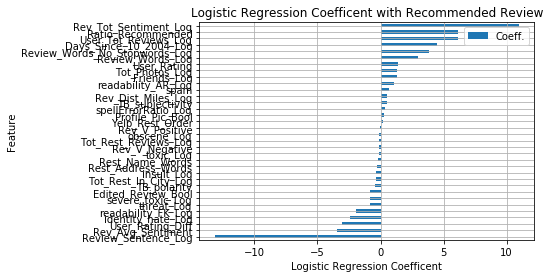

In [14]:
plt.figure(figsize = (15,15))
df[['Coeff.','Feature']].set_index('Feature').sort_values('Coeff.').plot(kind = 'barh', grid = 1,
                                        title ='Logistic Regression Coefficent with Recommended Review')

plt.xlabel('Logistic Regression Coefficent')
plt.ylabel('Feature')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [15]:
reviews = pd.read_csv('data/ready_data.csv')

#remove features if p value greater than 0.05
y = reviews['Recommended']
X = reviews.copy()
X.drop(columns=['Recommended', 'Yelp_Rest_Order', 'obscene_Log', 'severe_toxic_Log',
                'threat_Log', 'insult_Log', 'toxic_Log', 'Rev_V_Positive', 
                'spellErrorRatio_Log', 'identity_hate_Log', 'Tot_Rest_Reviews_Log'], inplace=True)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression(penalty='l2',class_weight='balanced')
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.5f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.79235


In [17]:
kfold = model_selection.KFold(n_splits=10, random_state=7)
scoring = 'accuracy'
results = model_selection.cross_val_score(logreg, X_train, y_train, cv=kfold, scoring=scoring)
print("10-fold cross validation average accuracy: %.5f" % (results.mean()))

10-fold cross validation average accuracy: 0.79152


In [18]:
confusion_matrix = pd.DataFrame(
    metrics.confusion_matrix(y_test, y_pred),
    columns=['Predicted Non Rec', 'Predicted Rec'],
    index=['Actual Non Rec', 'Actual Rec']
)
confusion_matrix

,Predicted Non Rec,Predicted Rec
Actual Non Rec,6672,1367
Actual Rec,14293,53082


In [19]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

        0.0       0.32      0.83      0.46      8039
        1.0       0.97      0.79      0.87     67375

avg / total       0.90      0.79      0.83     75414



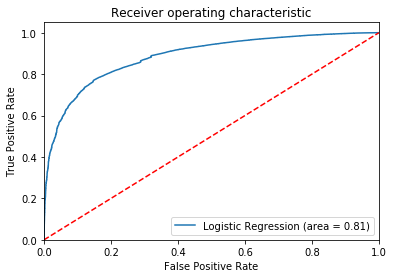

In [20]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [21]:
denom = (2.0*(1.0+np.cosh(logreg.decision_function(X))))
denom = np.tile(denom,(X.shape[1],1)).T
F_ij = np.dot((X/denom).T,X) ## Fisher Information Matrix
Cramer_Rao = np.linalg.inv(F_ij) ## Inverse Information Matrix
sigma_estimates = np.array([np.sqrt(Cramer_Rao[i,i]) for i in range(Cramer_Rao.shape[0])]) # sigma for each coefficient
z_scores = logreg.coef_[0]/sigma_estimates # z-score for eaach model coefficient
p_values = [stat.norm.sf(abs(x))*2 for x in z_scores] ### two tailed test for p-values

In [22]:
data = {'Feature': X.dtypes.index.tolist(), 'Coeff.': logreg.coef_[0].tolist(), 'P_Value': p_values, 'Z_Score': z_scores.tolist()}
data
df = pd.DataFrame(data=data,index=None)
df.round(5).set_index('Feature')

,Coeff.,P_Value,Z_Score
Feature,,,
Profile_Pic_Bool,0.24384,0.00000,17.30628
User_Rating,1.29685,0.00000,23.42455
Rev_Avg_Sentiment,-3.47447,0.00000,-21.73993
TB_polarity,-0.45947,0.00000,-7.10555
TB_subjectivity,0.45460,0.00000,10.44441
spam,0.66322,0.00000,19.97637
Rev_V_Negative,-0.11396,0.00000,-4.89002
Edited_Review_Bool,-0.80837,0.00000,-21.86232
Ratio_Recommended,6.23444,0.00000,110.14118


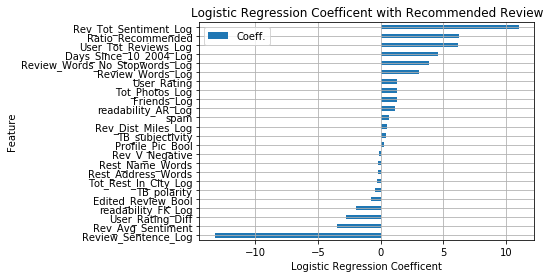

In [25]:
plt.figure(figsize = (15,15))
df[['Coeff.','Feature']].set_index('Feature').sort_values('Coeff.').plot(kind = 'barh', grid = 1,
                                        title ='Logistic Regression Coefficent with Recommended Review')

plt.xlabel('Logistic Regression Coefficent')
plt.ylabel('Feature')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [ ]:
confusion_matrix = pd.DataFrame(
    metrics.confusion_matrix(y_test, y_pred),
    columns=['Predicted Non Rec', 'Predicted Rec'],
    index=['Actual Non Rec', 'Actual Rec']
)

In [3]:
model = sm.Logit(endog=y, exog=X, missing='raise').fit()
y_pred_proba = model.predict(X)
model.summary2()

Optimization terminated successfully.
         Current function value: 0.486006
         Iterations 7


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                 Results: Logit
=================================================================================
Model:                    Logit                 No. Iterations:        7.0000    
Dependent Variable:       Recommended           Pseudo R-squared:      0.299     
Date:                     2018-06-23 00:01      AIC:                   51868.4764
No. Observations:         53292                 BIC:                   52170.5168
Df Model:                 33                    Log-Likelihood:        -25900.   
Df Residuals:             53258                 LL-Null:               -36939.   
Converged:                1.0000                Scale:                 1.0000    
---------------------------------------------------------------------------------
                               Coef.   Std.Err.    z     P>|z|   [0.025   0.975] 
---------------------------------------------------------------------------------
Profile_Pic_Bool                0.1450   0.0255   5.6960 0.0000   0.0951   0.1949
User_Rating                     0.8624   0.1072   8.0480 0.0000   0.6524   1.0724
Rev_Avg_Sentiment              -7.1940   0.2986 -24.0963 0.0000  -7.7792  -6.6089
TB_polarity                    -0.8589   0.1196  -7.1813 0.0000  -1.0934  -0.6245
TB_subjectivity                 0.4177   0.0797   5.2424 0.0000   0.2615   0.5739
spam                            0.1289   0.0677   1.9028 0.0571  -0.0039   0.2616
Rev_V_Negative                  0.0905   0.0486   1.8626 0.0625  -0.0047   0.1857
Rev_V_Positive                  0.0584   0.0284   2.0554 0.0398   0.0027   0.1141
Edited_Review_Bool             -0.7341   0.0694 -10.5717 0.0000  -0.8702  -0.5980
Yelp_Rest_Order                -0.0136   0.0470  -0.2905 0.7715  -0.1057   0.0784
Ratio_Recommended              -1.4360   0.0798 -17.9888 0.0000  -1.5925  -1.2796
Rest_Address_Words             -0.0998   0.0866  -1.1524 0.2492  -0.2694   0.0699
Rest_Name_Words                -0.1906   0.0718  -2.6542 0.0079  -0.3313  -0.0498
User_Rating_Diff               -2.3083   0.2098 -11.0001 0.0000  -2.7196  -1.8970
Friends_Log                     1.1016   0.0546  20.1843 0.0000   0.9946   1.2086
Days_Since_10_2004_Log          1.6521   0.1207  13.6915 0.0000   1.4156   1.8886
Review_Sentence_Log           -23.7450   0.9404 -25.2509 0.0000 -25.5880 -21.9019
Tot_Photos_Log                  1.3711   0.1112  12.3297 0.0000   1.1531   1.5890
User_Tot_Reviews_Log            6.0485   0.1015  59.5814 0.0000   5.8495   6.2475
Rev_Tot_Sentiment_Log          22.6226   0.9417  24.0219 0.0000  20.7768  24.4684
Tot_Rest_Reviews_Log           -0.9630   0.0691 -13.9269 0.0000  -1.0985  -0.8275
Tot_Rest_In_City_Log           -0.6876   0.1025  -6.7058 0.0000  -0.8886  -0.4866
Review_Words_Log                0.9399   0.5892   1.5952 0.1107  -0.2149   2.0948
Review_Words_No_Stopwords_Log   4.6747   0.6403   7.3005 0.0000   3.4197   5.9297
Rev_Dist_Miles_Log              0.7077   0.0474  14.9163 0.0000   0.6147   0.8007
spellErrorRatio_Log             0.4889   0.2316   2.1111 0.0348   0.0350   0.9429
toxic_Log                      -0.1824   0.1949  -0.9358 0.3494  -0.5645   0.1997
severe_toxic_Log              -10.9604   4.1465  -2.6433 0.0082 -19.0873  -2.8335
obscene_Log                     0.2033   0.4102   0.4956 0.6202  -0.6007   1.0072
threat_Log                      1.0774   1.8736   0.5751 0.5653  -2.5948   4.7497
insult_Log                     -0.3294   0.6199  -0.5314 0.5952  -1.5444   0.8856
identity_hate_Log              -1.3134   1.4431  -0.9101 0.3627  -4.1418   1.5150
readability_FK_Log             -0.4496   0.5036  -0.8927 0.3720  -1.4368   0.5375
readability_AR_Log             -0.3097   0.3731  -0.8300 0.4066  -1.0409   0.4216
=================================================================================

"""

# ROC curve

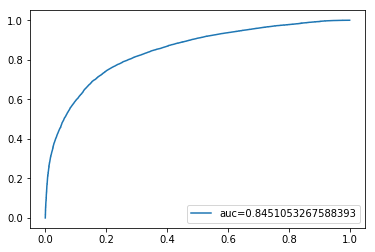

In [4]:
fpr, tpr, _ = metrics.roc_curve(y,  y_pred_proba)
auc = metrics.roc_auc_score(y, y_pred_proba)
plt.plot(fpr, tpr, label="auc="+str(auc))
plt.legend(loc=4)

# Choose a threshold value

In [5]:
threshold = .5
y_pred = (y_pred_proba > threshold).astype(int)

In [6]:
print('Accuracy Score:', metrics.accuracy_score(y, y_pred))
print('-'*50)
print('F1 Score:', metrics.f1_score(y, y_pred))
print('-'*50)
print('Precision:', metrics.precision_score(y, y_pred))
print('-'*50)
print('Recall:', metrics.recall_score(y, y_pred))
print('-'*50)
confusion_matrix = pd.DataFrame(
    metrics.confusion_matrix(y, y_pred),
    columns=['Predicted Non Rec', 'Predicted Rec'],
    index=['Actual Non Rec', 'Actual Rec']
)
confusion_matrix

Accuracy Score: 0.7710913457929895
--------------------------------------------------
F1 Score: 0.7621146233497785
--------------------------------------------------
Precision: 0.7932210269941141
--------------------------------------------------
Recall: 0.7333558507843578
--------------------------------------------------


,Predicted Non Rec,Predicted Rec
Actual Non Rec,21552,5094
Actual Rec,7105,19541


# Coefficient plot on scaled features linear Regression

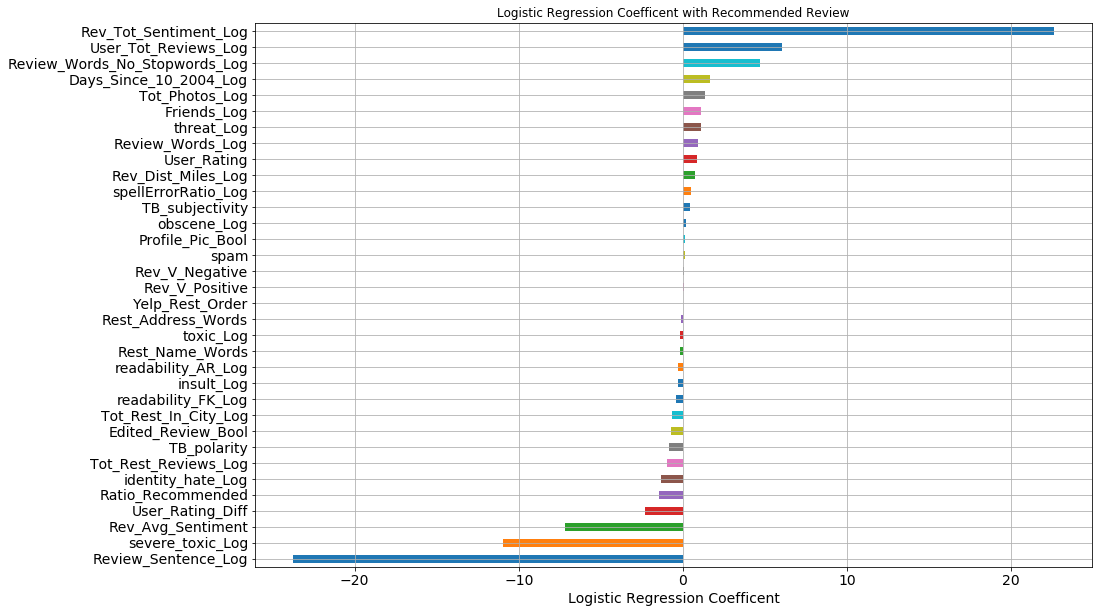

In [7]:
plt.figure(figsize = (15,10))
model.params[~model.params.index.isin(['Intercept'])].sort_values().plot(kind = 'barh', grid = 1, 
                                        title ='Logistic Regression Coefficent with Recommended Review')

plt.xlabel('Logistic Regression Coefficent', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

# <span style="color:blue">   Interpretation of model coefficients

## For the feature that is not log-transformed:
- Run 'Scale back' calculation using a value between 0 and 1, and get the feeling of the original value range
- Run 'Scale value' twice using reasonable values based on the previous step.  Double the amount of input values and tell how much the change of being 'regular' increased or decreased.

## For the feature that is log-transformed:
- Run 'Scale back' calculation using the correspondig coefficient value for a feature
- Say that multiplying the feature by 'e' increase the chance of 'regular' being 1 by the 'scale back' value.

### TBD:   type interpretation here once the final model is determined

# Read data again, with insignificant features removed

In [8]:
reviews = pd.read_csv('data/ready_data.csv')

#remove features if p value greater than 0.05
y = reviews['Recommended']
X = reviews.copy()
X.drop(columns=['Recommended', 'Yelp_Rest_Order', 'obscene_Log', 'insult_Log', 'threat_Log', 
                'readability_AR_Log', 'readability_FK_Log', 'identity_hate_Log', 'toxic_Log', 
                'Rest_Address_Words', 'Review_Words_Log', 'Rev_V_Negative', 'spam', 
                'spellErrorRatio_Log', 'Rest_Name_Words', 'Rev_V_Positive', ], inplace=True)

# Logistic Regression

In [9]:
model = sm.Logit(endog=y, exog=X, missing='raise').fit()
y_pred_proba = model.predict(X)
model.summary2()

Optimization terminated successfully.
         Current function value: 0.486333
         Iterations 7


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                 Results: Logit
=================================================================================
Model:                    Logit                 No. Iterations:        7.0000    
Dependent Variable:       Recommended           Pseudo R-squared:      0.298     
Date:                     2018-06-23 00:01      AIC:                   51873.3193
No. Observations:         53292                 BIC:                   52042.1066
Df Model:                 18                    Log-Likelihood:        -25918.   
Df Residuals:             53273                 LL-Null:               -36939.   
Converged:                1.0000                Scale:                 1.0000    
---------------------------------------------------------------------------------
                               Coef.   Std.Err.    z     P>|z|   [0.025   0.975] 
---------------------------------------------------------------------------------
Profile_Pic_Bool                0.1438   0.0254   5.6542 0.0000   0.0939   0.1936
User_Rating                     0.8848   0.1038   8.5249 0.0000   0.6813   1.0882
Rev_Avg_Sentiment              -7.2554   0.2811 -25.8101 0.0000  -7.8064  -6.7045
TB_polarity                    -0.8466   0.1177  -7.1918 0.0000  -1.0773  -0.6159
TB_subjectivity                 0.3762   0.0778   4.8369 0.0000   0.2237   0.5286
Edited_Review_Bool             -0.7254   0.0691 -10.4970 0.0000  -0.8608  -0.5899
Ratio_Recommended              -1.4251   0.0766 -18.5974 0.0000  -1.5753  -1.2749
User_Rating_Diff               -2.3595   0.2029 -11.6288 0.0000  -2.7572  -1.9618
Friends_Log                     1.0997   0.0545  20.1674 0.0000   0.9928   1.2066
Days_Since_10_2004_Log          1.5108   0.1112  13.5866 0.0000   1.2928   1.7287
Review_Sentence_Log           -23.6377   0.8997 -26.2734 0.0000 -25.4011 -21.8744
Tot_Photos_Log                  1.3772   0.1108  12.4244 0.0000   1.1600   1.5945
User_Tot_Reviews_Log            6.0533   0.1009  60.0120 0.0000   5.8556   6.2510
Rev_Tot_Sentiment_Log          22.8509   0.8813  25.9298 0.0000  21.1236  24.5781
Tot_Rest_Reviews_Log           -0.9890   0.0672 -14.7193 0.0000  -1.1206  -0.8573
Tot_Rest_In_City_Log           -0.7200   0.0962  -7.4815 0.0000  -0.9086  -0.5314
Review_Words_No_Stopwords_Log   5.3002   0.1704  31.0981 0.0000   4.9661   5.6342
Rev_Dist_Miles_Log              0.7003   0.0474  14.7887 0.0000   0.6075   0.7931
severe_toxic_Log              -12.9134   3.6760  -3.5129 0.0004 -20.1183  -5.7085
=================================================================================

"""

# ROC curve

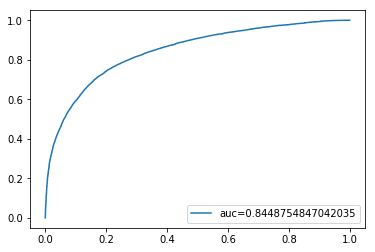

In [10]:
fpr, tpr, _ = metrics.roc_curve(y,  y_pred_proba)
auc = metrics.roc_auc_score(y, y_pred_proba)
plt.plot(fpr, tpr, label="auc="+str(auc))
plt.legend(loc=4)

# Choose a threshold value

In [11]:
threshold = .5
y_pred = (y_pred_proba > threshold).astype(int)

In [12]:
print('Accuracy Score:', metrics.accuracy_score(y, y_pred))
print('-'*50)
print('F1 Score:', metrics.f1_score(y, y_pred))
print('-'*50)
print('Precision:', metrics.precision_score(y, y_pred))
print('-'*50)
print('Recall:', metrics.recall_score(y, y_pred))
print('-'*50)
confusion_matrix = pd.DataFrame(
    metrics.confusion_matrix(y, y_pred),
    columns=['Predicted Non Rec', 'Predicted Rec'],
    index=['Actual Non Rec', 'Actual Rec']
)
confusion_matrix

Accuracy Score: 0.7702094122945282
--------------------------------------------------
F1 Score: 0.7610909516563268
--------------------------------------------------
Precision: 0.7925402242808386
--------------------------------------------------
Recall: 0.7320423328079262
--------------------------------------------------


,Predicted Non Rec,Predicted Rec
Actual Non Rec,21540,5106
Actual Rec,7140,19506


# Coefficient plot on scaled features Logistic Regression

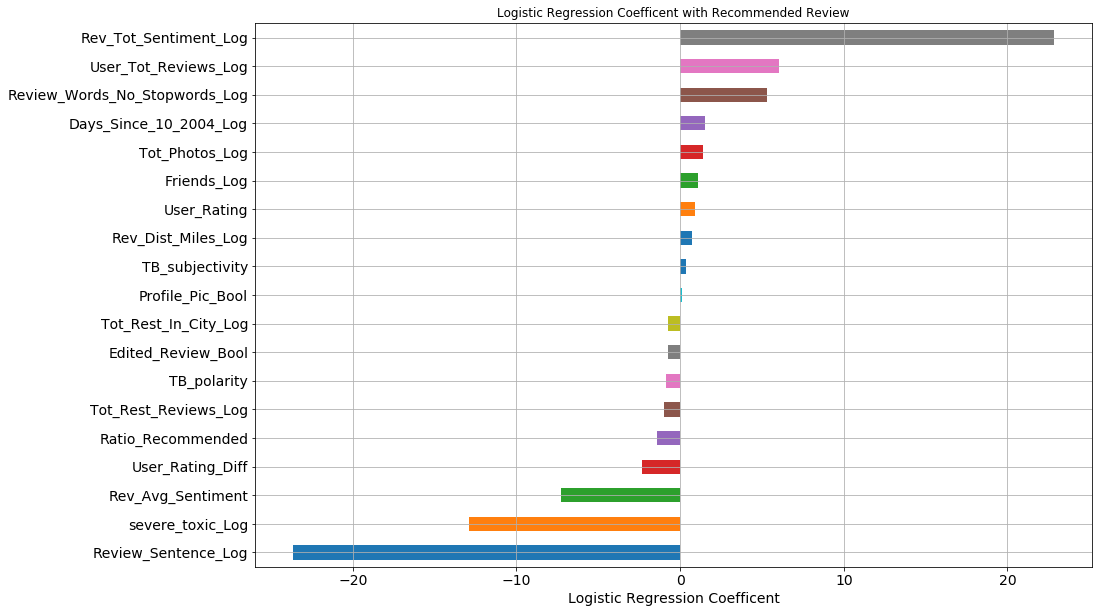

In [13]:
plt.figure(figsize = (15,10))
model.params[~model.params.index.isin(['Intercept'])].sort_values().plot(kind = 'barh', grid = 1, 
                                        title ='Logistic Regression Coefficent with Recommended Review')

plt.xlabel('Logistic Regression Coefficent', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()